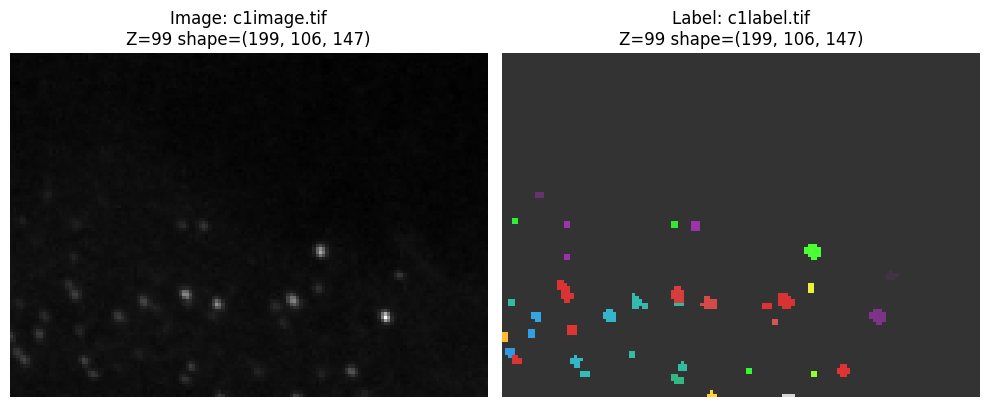

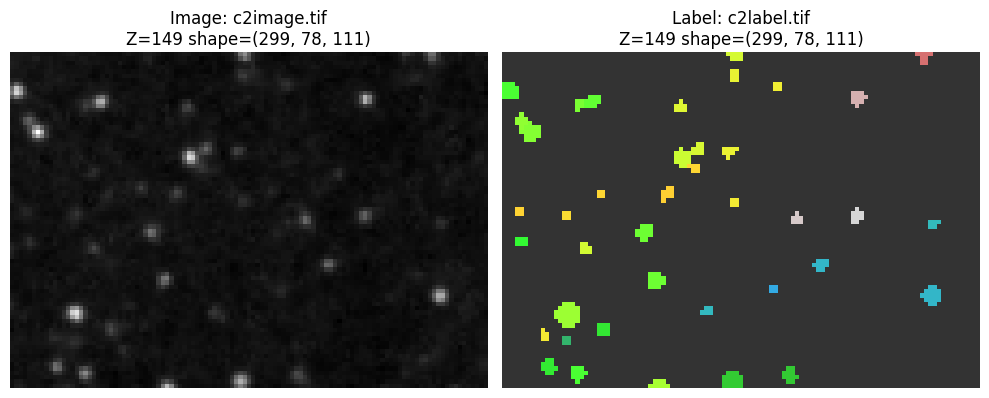

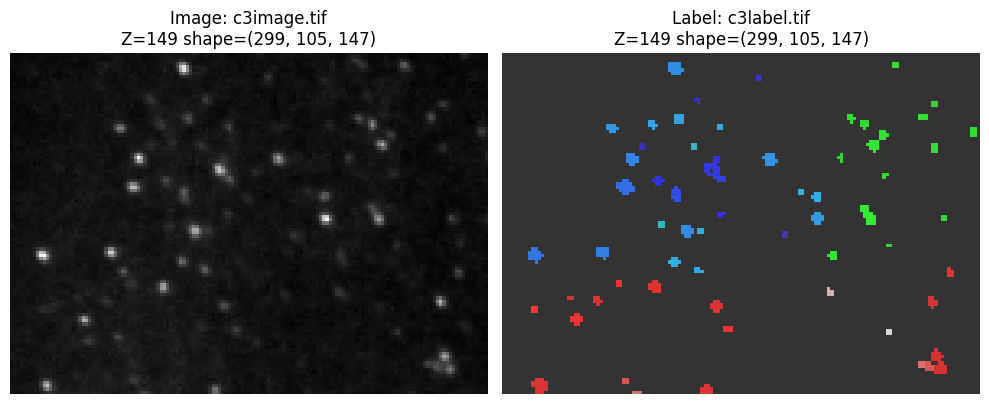

In [1]:
import os
from pathlib import Path
import tifffile
import numpy as np
import matplotlib.pyplot as plt

# Directory containing the dataset (edit as needed)
base_dir = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/prepared")
images_dir = base_dir / "images"
labels_dir = base_dir / "labels"

# List of image files (sort for consistency)
image_files = sorted(images_dir.glob("*.tif"))
label_files = sorted(labels_dir.glob("*.tif"))

# Visualize each image-label pair (max 3 pairs for brevity)
for img_f, lbl_f in zip(image_files[:3], label_files[:3]):
    img = tifffile.imread(img_f)
    lbl = tifffile.imread(lbl_f)

    mid_slice = img.shape[0] // 2  # Show central Z slice

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img[mid_slice], cmap='gray')
    axs[0].set_title(f"Image: {img_f.name}\nZ={mid_slice} shape={img.shape}")
    axs[1].imshow(lbl[mid_slice], cmap='nipy_spectral', alpha=0.8)
    axs[1].set_title(f"Label: {lbl_f.name}\nZ={mid_slice} shape={lbl.shape}")
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()


In [32]:
from pathlib import Path
import pandas as pd

# Path from test_inference_swin_unetr.yaml:
# datasets.hypercubes_dataframe_path:
#   ${paths.data_path}/tests/databases/prepared_1_128_128_128_2_hypercube_view.csv
roi_csv = Path(
    "/clusterfs/nvme/segment_3d/tests/databases/"
    "prepared_1_128_128_128_2_hypercube_view_rois.csv"
)

df = pd.read_csv(roi_csv)

# Apply the same renaming logic as Inferencer._get_data_tiles_metadata
cols_rename = [
    "tile_z_start", "tile_y_start", "tile_x_start",
    "tile_z_end", "tile_y_end", "tile_x_end",
    "tile_channel_size", "tile_time_size",
]
if set(cols_rename).issubset(df.columns):
    df = df.rename(
        columns={
            "prepared_id": "id",
            "tile_z_end": "z_end",
            "tile_y_end": "y_end",
            "tile_x_end": "x_end",
            "tile_z_start": "z_start",
            "tile_y_start": "y_start",
            "tile_x_start": "x_start",
            "tile_time_size": "time_size",
            "tile_channel_size": "channel_size",
        }
    )

volume_rows = df[(df["z_start"] != df["z_end"])]
volume_ids = volume_rows["id"].unique()
# volume_rows = df[(df["z_start"] != df["z_end"]) & (df["id"] > 300)]

# rows = df[(df["id"] ==319)]
print(volume_rows[["id", "z_start", "z_end", "y_start", "y_end", "x_start", "x_end"]].sort_values(by="id"))


      id  z_start  z_end  y_start  y_end  x_start  x_end
50    17       25    153       61    445       19   2835
51    18       25    153       61    445       19   2835
52    19       25    153       61    445       19   2835
53    20       25    153       61    445       19   2835
54    21       25    153       61    445       19   2835
..   ...      ...    ...      ...    ...      ...    ...
171  370       25    153       61    445        7   2567
172  371       25    153       61    445        7   2567
173  372       25    153       61    445        7   3335
174  373       25    153       61    445        7   3335
177  374       25    153       61    445        7   3335

[185 rows x 7 columns]


{np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30),
 np.int64(31),
 np.int64(32),
 np.int64(33),
 np.int64(34),
 np.int64(35),
 np.int64(36),
 np.int64(37),
 np.int64(38),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(42),
 np.int64(43),
 np.int64(45),
 np.int64(46),
 np.int64(47),
 np.int64(48),
 np.int64(49),
 np.int64(50),
 np.int64(51),
 np.int64(52),
 np.int64(53),
 np.int64(54),
 np.int64(55),
 np.int64(56),
 np.int64(58),
 np.int64(59),
 np.int64(60),
 np.int64(61),
 np.int64(62),
 np.int64(63),
 np.int64(64),
 np.int64(65),
 np.int64(66),
 np.int64(67),
 np.int64(68),
 np.int64(69),
 np.int64(72),
 np.int64(73),
 np.int64(74),
 np.int64(75),
 np.int64(76),
 np.int64(77),
 np.int64(78),
 np.int64(79),
 np.int64(80),
 np.int64(81),
 np.int64(82),
 np.int64(83),
 np.int64(84),
 np.int64(85),
 np.int64(86),
 np.int64(

In [43]:
from pathlib import Path
import pandas as pd
from collections import defaultdict

base = Path("/clusterfs/nvme/segment_3d/tests/databases")
hypercube_csv = base / "prepared_1_128_128_128_2_hypercube_view.csv"

# Print the columns of the CSV
sample = pd.read_csv(hypercube_csv, nrows=0)
print("Columns:", list(sample.columns))


roi_ids = set(volume_ids.tolist())

tiles_by_roi: dict[int, set[str]] = defaultdict(set)

chunksize = 1_000_000  # adjust as needed
usecols = ["prepared_id", "tile_name", "exists", "is_synthetic"]

out = []
for chunk in pd.read_csv(hypercube_csv, chunksize=chunksize, usecols=usecols):
    # Filter by ROI first to keep memory small
    sub = chunk[chunk["prepared_id"].isin(roi_ids)]
    out.append(sub.to_dict(orient="records"))


Columns: ['first_pc_id', 'prepared_id', 'time_start', 'x_start', 'y_start', 'z_start', 'time_size', 'pc_metadata_json', 'channel_size', 'cube_size', 'tile_name', 'channel_targets', 'occupancy_ratios_ch_0', 'occupancy_ratios_ch_1', 'server_folder', 'output_folder', 'p_metadata_json', 'exists', 'exists_prfs', 'exists_aws', 'exists_oak', 'metadata_tile_json', 'json_excite_map_total', 'unique_targets', 'imaged_locations', 'date_crossed', 'hpf', 'is_synthetic']


Exception ignored in: <function tqdm.__del__ at 0x7f44451f47c0>
Traceback (most recent call last):
  File "/clusterfs/nvme/martinalvarez/miniforge3/envs/segproj/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/clusterfs/nvme/martinalvarez/miniforge3/envs/segproj/lib/python3.12/site-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7f44451f47c0>
Traceback (most recent call last):
  File "/clusterfs/nvme/martinalvarez/miniforge3/envs/segproj/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/clusterfs/nvme/martinalvarez/miniforge3/envs/segproj/lib/python3.12/site-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute '

In [50]:
dfs = []
for d in out:
    df_d = pd.DataFrame.from_records(d)
    dfs.append(df_d)
df_out = pd.concat(dfs)

In [51]:
print(df_out.head())

   prepared_id            tile_name  exists  is_synthetic
0           17  000x_000y_000z.zarr       1             0
1           17  000x_000y_000z.zarr       1             0
2           17  000x_000y_000z.zarr       1             0
3           17  000x_000y_000z.zarr       1             0
4           17  000x_000y_000z.zarr       1             0


In [ ]:
df_out[df_out["exists"].astype(bool) & df_out["is_synthetic"].astype(bool)].value_counts()

prepared_id  tile_name            exists  is_synthetic
165          000x_000y_000z.zarr  1       1               208
166          000x_000y_000z.zarr  1       1               208
Name: count, dtype: int64

: 

In [27]:
# Print the columns of the CSV
sample = pd.read_csv(hypercube_csv, nrows=0)
print("Columns:", list(sample.columns))



Columns: ['first_pc_id', 'prepared_id', 'time_start', 'x_start', 'y_start', 'z_start', 'time_size', 'pc_metadata_json', 'channel_size', 'cube_size', 'tile_name', 'channel_targets', 'occupancy_ratios_ch_0', 'occupancy_ratios_ch_1', 'server_folder', 'output_folder', 'p_metadata_json', 'exists', 'exists_prfs', 'exists_aws', 'exists_oak', 'metadata_tile_json', 'json_excite_map_total', 'unique_targets', 'imaged_locations', 'date_crossed', 'hpf', 'is_synthetic']


In [40]:
set(volume_ids.tolist())

{17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 165,
 166,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,